Figure 2

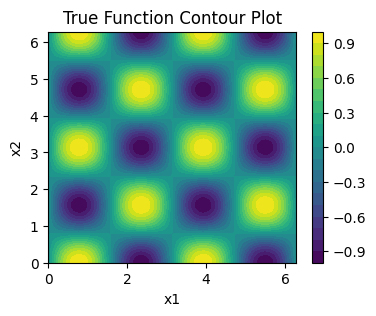

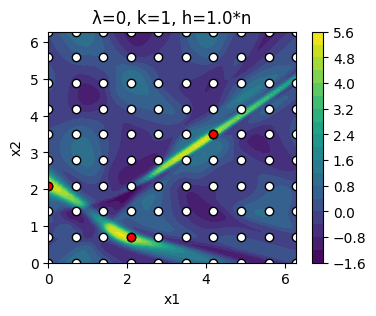

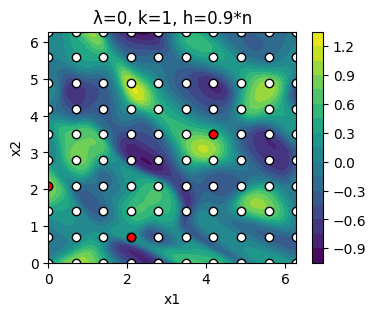

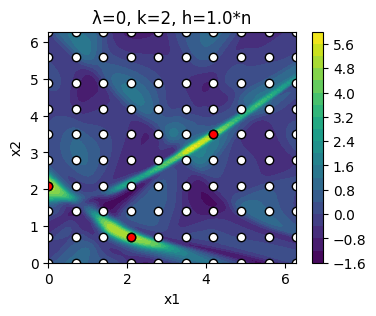

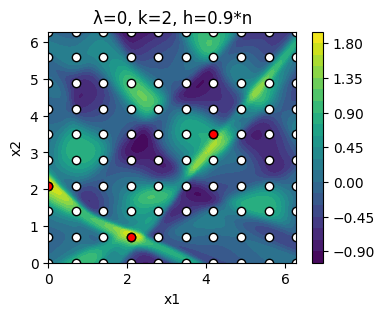

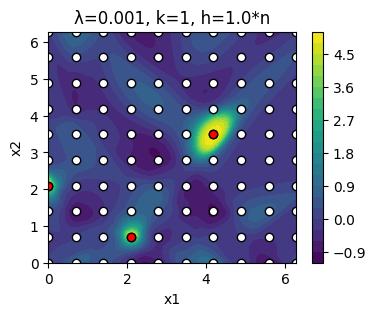

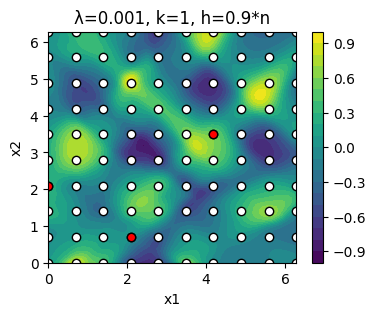

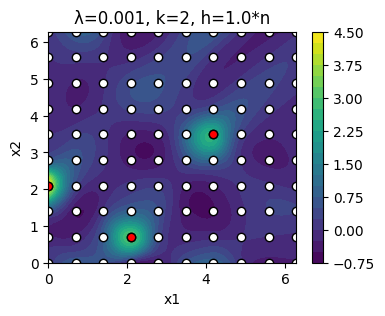

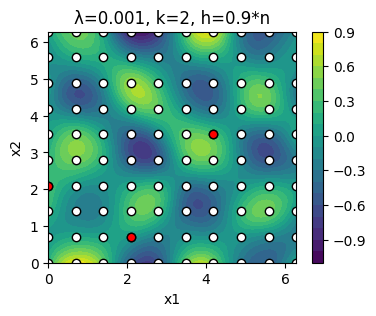

λ=0, k=1, h=1.0*n
PMSE Mean: 0.7997, PMSE Std: 0.1798
--------------------------------------------------
λ=0, k=1, h=0.9*n
PMSE Mean: 0.0939, PMSE Std: 0.0078
--------------------------------------------------
λ=0, k=2, h=1.0*n
PMSE Mean: 0.7791, PMSE Std: 0.0945
--------------------------------------------------
λ=0, k=2, h=0.9*n
PMSE Mean: 0.1867, PMSE Std: 0.0207
--------------------------------------------------
λ=0.001, k=1, h=1.0*n
PMSE Mean: 0.4480, PMSE Std: 0.1102
--------------------------------------------------
λ=0.001, k=1, h=0.9*n
PMSE Mean: 0.0679, PMSE Std: 0.0061
--------------------------------------------------
λ=0.001, k=2, h=1.0*n
PMSE Mean: 0.3559, PMSE Std: 0.0568
--------------------------------------------------
λ=0.001, k=2, h=0.9*n
PMSE Mean: 0.0638, PMSE Std: 0.0046
--------------------------------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

n = 10**2
x1 = np.linspace(0, 2 * np.pi, int(np.sqrt(n)))
x2 = np.linspace(0, 2 * np.pi, int(np.sqrt(n)))
x1_grid, x2_grid = np.meshgrid(x1, x2)
x1_flat = x1_grid.flatten()
x2_flat = x2_grid.flatten()
X = np.vstack((x1_flat, x2_flat)).T
y_true = np.sin(2 * x1_flat) * np.cos(2 * x2_flat)

y = y_true + np.random.normal(0, 0.2, x1_flat.shape[0])

# Outliers
n_outliers = int(n * 0.03) # 3% outliers
random_indices = np.random.choice(np.arange(n), size=n_outliers, replace=False)
y[random_indices] = 5 + np.random.uniform(-0.1, 0.1, n_outliers)

outlier_indices = random_indices

class SimpleNN(nn.Module):
    def __init__(self, input_dim=2, activation_func='sigmoid'):
        super(SimpleNN, self).__init__()
        self.first = nn.Linear(input_dim, 100)
        self.hidden1 = nn.Linear(100, 100)
        self.hidden2 = nn.Linear(100, 100)
        self.hidden3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 1)
        if activation_func == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_func == 'relu':
            self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.first(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        return self.output(x)

# HOVR
def hovr_regularization(model, x, k=3, q=2, M=10):
    x_min = x.min(dim=0).values
    x_max = x.max(dim=0).values
    random_points = torch.tensor(np.random.uniform(x_min.numpy(), x_max.numpy(), (M, x.shape[1])), dtype=torch.float32, requires_grad=True)

    preds = model(random_points)
    grads = torch.autograd.grad(preds, random_points, grad_outputs=torch.ones_like(preds), create_graph=True)[0]

    hovr_term = 0.0
    n_dims = x.shape[1]
    for i in range(n_dims):
        grad_i = grads[:, i]
        temp_grad = grad_i
        for _ in range(k - 1):
            temp_grad = torch.autograd.grad(temp_grad, random_points, grad_outputs=torch.ones_like(temp_grad), create_graph=True)[0][:, i]
        hovr_term += (1 / n_dims) * torch.sum(torch.abs(temp_grad) ** q)

    return hovr_term

# Transformed Trimmed Loss + HOVR
def transformed_ttl_hovr_loss(model, xi, x, y, h, lambd, k, q):
    n = x.shape[0]
    preds = model(x)
    residuals = (y - preds).reshape(-1, 1)

    loss_fit = (1 / n) * torch.sum((residuals - xi) ** 2)

    # T_h(xi)
    xi_abs = torch.abs(xi).reshape(-1)
    xi_squared = xi_abs ** 2
    T_h_xi = (1 / n) * torch.sum(torch.topk(xi_squared, h, largest=False)[0])
    hovr_term = lambd * hovr_regularization(model, x, k, q)
    total_loss = loss_fit + T_h_xi + hovr_term

    return total_loss

X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

lambda_values = [0, 1e-3]
k_values = [1, 2]
q = 2

x1_lin = np.linspace(0, 2 * np.pi, 100)
x2_lin = np.linspace(0, 2 * np.pi, 100)
x1_grid_full, x2_grid_full = np.meshgrid(x1_lin, x2_lin)
X_grid_full = np.vstack((x1_grid_full.flatten(), x2_grid_full.flatten())).T
y_true_full = np.sin(2 * X_grid_full[:, 0]) * np.cos(2 * X_grid_full[:, 1])
y_true_full = y_true_full.reshape(x1_grid_full.shape)

plt.figure(figsize=(4, 3))
plt.contourf(x1_grid_full, x2_grid_full, y_true_full, levels=20, cmap='viridis')
plt.colorbar()
plt.title('True Function Contour Plot')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

outlier_indices = random_indices

pmse_results = []

for i, lambd in enumerate(lambda_values):
    for j, k_val in enumerate(k_values):
        for h_factor in [1, 0.9]:
            model = SimpleNN(input_dim=2)
            n_params = X_torch.shape[0]
            xi = nn.Parameter(torch.zeros(n_params, 1, dtype=torch.float32), requires_grad=True)

            optimizer = optim.Adam(list(model.parameters()) + [xi], lr=0.01)

            epochs = 5000
            h = int(h_factor * n_params)
            for epoch in range(epochs):
                optimizer.zero_grad()
                loss = transformed_ttl_hovr_loss(model, xi, X_torch, y_torch, h=h, lambd=lambd, k=k_val, q=q)
                loss.backward()
                optimizer.step()

            X_grid_torch = torch.tensor(X_grid_full.reshape(-1, 2), dtype=torch.float32)
            with torch.no_grad():
                y_grid_pred = model(X_grid_torch).detach().numpy().reshape(x1_grid_full.shape)

            plt.figure(figsize=(4, 3))
            plt.contourf(x1_grid_full, x2_grid_full, y_grid_pred, levels=20, cmap='viridis')
            plt.colorbar()
            plt.scatter(X[:, 0], X[:, 1], c='white', edgecolors='black', label='Regular Data')
            plt.scatter(X[outlier_indices, 0], X[outlier_indices, 1], c='red', edgecolors='black', label='Outliers')
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.title(f'λ={lambd}, k={k_val}, h={h_factor:.1f}*n')
            plt.show()

            pmse_list = []
            for _ in range(20):
                n_test = 500
                x1_test = np.random.uniform(0, 2 * np.pi, n_test)
                x2_test = np.random.uniform(0, 2 * np.pi, n_test)
                X_test = np.vstack((x1_test, x2_test)).T
                y_test_true = np.sin(2 * x1_test) * np.cos(2 * x2_test)
                y_test_noisy = y_test_true + np.random.normal(0, 0.2, n_test)

                X_test_torch = torch.tensor(X_test, dtype=torch.float32)
                y_test_torch = torch.tensor(y_test_noisy.reshape(-1, 1), dtype=torch.float32)

                with torch.no_grad():
                    y_test_pred = model(X_test_torch).detach().numpy().reshape(-1)

                mse = np.mean((y_test_true - y_test_pred) ** 2)
                pmse_list.append(mse)

            pmse_mean = np.mean(pmse_list)
            pmse_std = np.std(pmse_list)
            pmse_results.append({
                'lambda': lambd,
                'k': k_val,
                'h_factor': h_factor,
                'pmse_mean': pmse_mean,
                'pmse_std': pmse_std
            })

for result in pmse_results:
    print(f"λ={result['lambda']}, k={result['k']}, h={result['h_factor']:.1f}*n")
    print(f"PMSE Mean: {result['pmse_mean']:.4f}, PMSE Std: {result['pmse_std']:.4f}")
    print('-' * 50)